In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from pythainlp.tokenize import word_tokenize
import emoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from visualize import top_feats_all, plot_top_feats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df = df.drop(df.columns[0], axis=1)
comments = df['comments']

In [4]:
comments

0      ดีค่ะ วิทยากรมีความรู้ดีมาก พูดเข้าใจ การสอนมี...
1      ชอบมาก เหมาะสมหรับผู้ที่มีผู้ฐานเรื่องการตลาด ...
2      คอร์สเนื้อหาแน่น และผู้สอนก็สอนได้ละเอียด มีขั...
3      คอร์สนี้ช่วยให้หลักการและกรอบในการดำเนินงานด้า...
4          สอนแบบมี Logic และ วิธีการที่ชัดเจน ชอบมากค่ะ
                             ...                        
884    เหมาะสมกับทั้งคนที่ยังไม่มีพื้นฐาน และคนที่อยา...
885    อันนี้รีวิว หลังจากดูจบแล้วครับ\nเกรินก่อน ผมเ...
886    อ.บอย สอนได้ละเอียดมากครับ\nแต่ถ้าเอาไปเขียนเอ...
887    สอนได้ละเอียดกระชับและชัดเจน เข้าใจได้ง่ายครับ...
888                                        ดีสุดๆเลยครับ
Name: comments, Length: 889, dtype: object

In [5]:
#from pythainlp.corpus.common import thai_stopwords
#thai_stopwords = list(thai_stopwords())
stopwords = ['ที่','และ','เป็น','มี','ให้','ครับ','ค่ะ','ใน','ได้','การ','มา','ๆ','นี้','ไป','จะ','ครับ']

In [6]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    res = text.lower().strip() 
    res = replace_url(text)
    res = [word for word in word_tokenize(text) if word not in stopwords and not re.search(pattern=r"\s+", string=word)]
    res = ungroup_emoji(res)
    return res

In [7]:
import pickle
pos_neg = pickle.load(open('sentiment_analysis.pkl', 'rb'))

array(['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos',
       'pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos',
       'neg', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos',
       'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg',
       'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg',
       'pos', 'pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg',
       'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg',
       'pos', 'pos',

In [8]:
d = {'comments': comments, 'sentiment': pos_neg.predict(comments)}
df = pd.DataFrame(d)
df

,comments,sentiment
0,ดีค่ะ วิทยากรมีความรู้ดีมาก พูดเข้าใจ การสอนมี...,pos
1,ชอบมาก เหมาะสมหรับผู้ที่มีผู้ฐานเรื่องการตลาด ...,pos
2,คอร์สเนื้อหาแน่น และผู้สอนก็สอนได้ละเอียด มีขั...,pos
3,คอร์สนี้ช่วยให้หลักการและกรอบในการดำเนินงานด้า...,pos
4,สอนแบบมี Logic และ วิธีการที่ชัดเจน ชอบมากค่ะ,pos
...,...,...
884,เหมาะสมกับทั้งคนที่ยังไม่มีพื้นฐาน และคนที่อยา...,neg
885,อันนี้รีวิว หลังจากดูจบแล้วครับ\nเกรินก่อน ผมเ...,pos
886,อ.บอย สอนได้ละเอียดมากครับ\nแต่ถ้าเอาไปเขียนเอ...,pos
887,สอนได้ละเอียดกระชับและชัดเจน เข้าใจได้ง่ายครับ...,pos


In [9]:
tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), sublinear_tf=True)
tfidf_fit = tfidf.fit(df['comments'])
text_df = tfidf_fit.transform(df['comments'])

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
features = tfidf_fit.get_feature_names()
ts = top_feats_all(text_df.toarray(), df['sentiment'], features)
print('Positive')
pos_rank = pd.DataFrame(ts[1])
pos_rank.set_index('rank')
print(pos_rank.head(10))
print('Negative')
neg_rank = pd.DataFrame(ts[0])
neg_rank.set_index('rank')
print(neg_rank.head(10))

Positive
   rank         feature     score  ngram label
0     0           ดีมาก  0.027199      1   pos
1     1      เข้าใจง่าย  0.025971      1   pos
2     2              ดี  0.022276      1   pos
3     3             มาก  0.017438      1   pos
4     4             สอน  0.017132      1   pos
5     5          อธิบาย  0.012353      1   pos
6     6             เลย  0.012028      1   pos
7     7          ชัดเจน  0.010382      1   pos
8     8          สามารถ  0.010302      1   pos
9     9  สอน เข้าใจง่าย  0.010279      2   pos
Negative
   rank  feature     score  ngram label
0     0      ไม่  0.021009      1   neg
1     1     อยาก  0.019330      1   neg
2     2  มากกว่า  0.017099      1   neg
3     3    เพิ่ม  0.013132      1   neg
4     4      ยัง  0.012120      1   neg
5     5  พื้นฐาน  0.012118      1   neg
6     6   เหมือน  0.011798      1   neg
7     7     ก่อน  0.010889      1   neg
8     8    แต่ละ  0.010704      1   neg
9     9   เข้าใจ  0.010338      1   neg


/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
import matplotlib as plt
plt.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
plt.rc('font', family='TH Sarabun New')

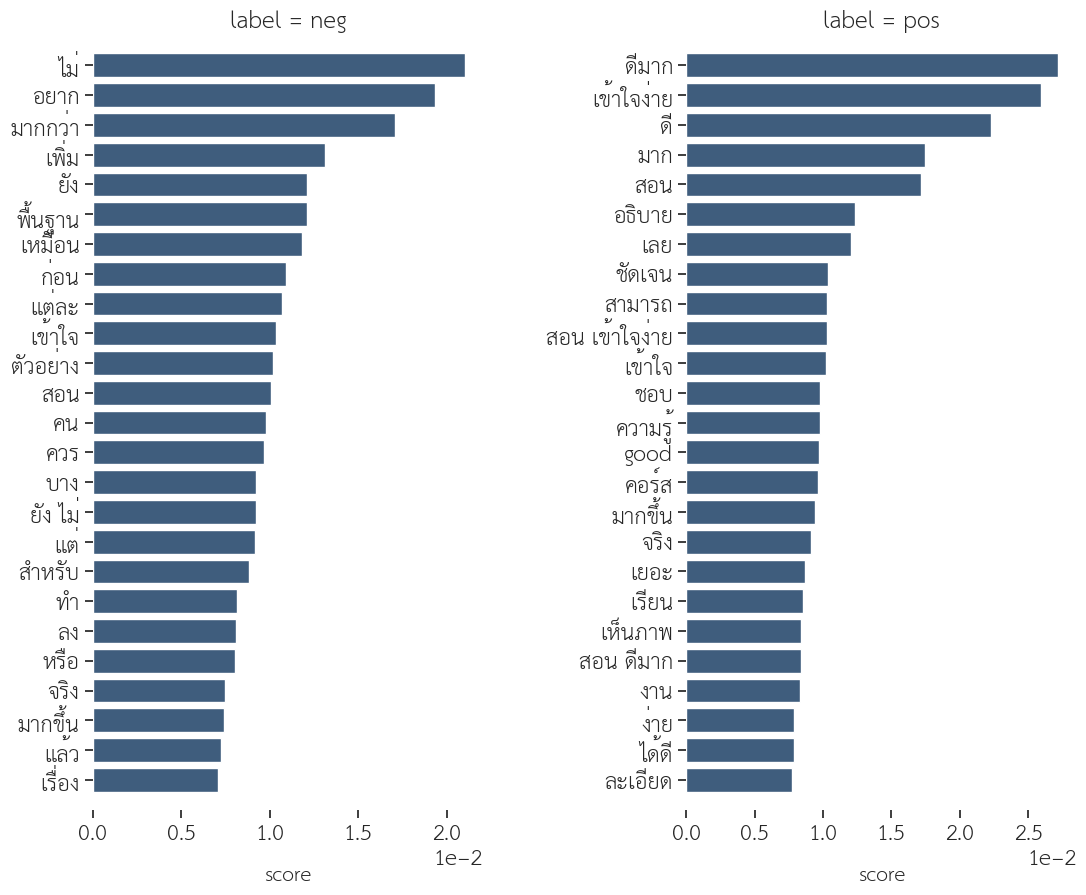

In [38]:
plot_top_feats(ts)

In [27]:
pos_rank.feature[:10]

0             ดีมาก
1        เข้าใจง่าย
2                ดี
3               มาก
4               สอน
5            อธิบาย
6               เลย
7            ชัดเจน
8            สามารถ
9    สอน เข้าใจง่าย
Name: feature, dtype: object

In [22]:
neg_no = int(input('type negative keyword ranking:'))
neg_no = neg_no-1
print('Keyword:', neg_rank['feature'][neg_no])
for i in df['comments'][df['comments'].str.contains(neg_rank['feature'][neg_no])].loc[df['sentiment']=='neg']:
    print(i)

Keyword: ไม่
ยังรู้สึกไม่ตรงตามความต้องการ เนื้อหาไม่ละเอียด
อาจารย์สอนเข้าใจดี ขาดเทคนิดในการสอนให้น่าติดตาม และการตัดต่อเยอะๆส่งผลให้ผู้ฟัง งง กับความต่อเนื่อง ทรงผมของผู้สอน ทำให้เกิดความไม่จริงหรือไม่น่าติดตามครับ
เป็นคลิปสั้น เข้าใจง่ายๆ ในแต่ละบทเรียน ถ้าไม่เข้าใจ สามารถกดเรียนซ้ำได้โดนไม่ต้องกดหา
ได้ความรู้เยอะขึ้นมาก
ข้อมูลละเอียดมาก สำหรับคนที่ไม่มีประสบการณ์ด้านสาขานี้มาก่อน
จากไม่รู้จริง ตอนนี้มี line bot แล้ว จบคอร์สทำได้จริง
เหมาะสำหรับคนที่ไม่มีพื้นฐานอย่างยิ่ง
ลิงค์ไม่ได้อัพเดทมากนัก ต้องไปควานหาเอาในอากู๋เองพอสมควร แต่นอกนั้นก็สอนโอเคเลยนะ
มีการข้ามหัวข้อสร้าง Chat  Bot ไปทำให้คนที่สร้างไม่เป็นถึงขั้นงงเป็นไก่ตาแตกได้
รู้สึกว่าคอร์สมันทั้งลึกไปและตื้นไป Quizบางอันที่ให้ทำcomplexมากเกินกว่าระดับคนไม่มีพื้นฐานมาก่อนและมีassumed knowledgeว่านักเรียนจะรู้แล้วหลายที่มากเกินไป ในหลายQuiz มันจะมีฟังก์ชันที่เราจะต้องใช้ทำคำตอบแต่ว่าก่อนหน้านั้นคอร์สไม่ได้มีการอธิบายอะไรเลยว่าแต่ละcommandมีไว้ใช้ทำอะไร ใช้ในสถานการณ์ไหน มีแค่บอกให้queryและลองดูผลลัพธ์กันเอง โดยรวมแล้วคอร์สโอเคเพ

In [ ]:
df['comments'][865]

In [ ]:
import pickle
sample = ['สอนดีมากๆค่ะ','อยากให้สอนได้ละเอียดมากกว่านี้','สอนค่อนข้างดี แต่อยากได้ตัวอย่าง','ไม่สนุกเลย','อยากให้เพิ่มเนื้อหา','สอนละเอียดมากครับ']
pickled_model = pickle.load(open('sentiment_analysis.pkl', 'rb'))
pickled_model.predict(sample)

In [ ]:
pos_clus = pickle.load(open('pos_clustering.pkl', 'rb'))
pos_clus.predict(sample)